In [0]:
from google.colab import drive
drive.mount._DEBUG = True
#drive.mount('/content/gdrive/', force_remount=True)
drive.mount('/content/gdrive/')
#!ls /content/gdrive/'My Drive'/Deeplearning/RA_Work/NEMD_Simulations/all_data/data_dump.pk

export PS1="root@1790f9a1673e-cd2117c6a977412a95160d768dfe64a9: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
root@1790f9a1673e:/content# root@1790f9a1673e-cd2117c6a977412a95160d768dfe64a9: umount -f /content/gdrive/ || umount /content/gdrive/; pkill -9 -x drive
umount: /content/gdrive/: no mount point specified.
umount: /content/gdrive/: no mount point specified.
root@1790f9a1673e-cd2117c6a977412a95160d768dfe64a9: ( while `sleep 0.5`; do if [[ -d "/content/gdrive/" && "$(ls -A /content/gdrive/)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 156
root@1790f9a1673e-cd2117c6a977412a95160d768dfe64a9: cat /tmp/tmppf7cd11m/drive.fifo | head -1 | ( /opt/google/drive/drive --features=max_parallel_push_task_instances:10,max_operation_batch_size:15,opendir_timeout_ms:60000,virtual_folders:true --inet_family=IPV4_ONLY --preferences=trusted_root_certs_file_path:/opt/google/drive/roots.pem,mount_point_pa

In [0]:
!ls /content/gdrive/'My Drive'/Deeplearning/RA_Work/Many_particle_16_RNN_pb/data
working_dir = '/content/gdrive/My Drive/Deeplearning/RA_Work/Many_particle_16_RNN_pb'

data_dump_many_particle_dic_16.pk


In [0]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow 2.x selected.
2.1.0-rc1
/device:GPU:0
Num GPUs Available:  1


In [0]:
#Lib imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
from sklearn.metrics import confusion_matrix
import sys, os, io, string, shutil, math
import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from sklearn import preprocessing
from IPython.display import display
import scipy.linalg as la
import re
from tabulate import tabulate
from scipy import stats
import pickle
from sklearn.utils import shuffle
import random
import time

tf.__version__

'2.1.0-rc1'

In [0]:
file_name = '/data/data_dump_many_particle_dic_16.pk'
#file_name = '/data/simple_data2.pk'
with open(working_dir+file_name, 'rb') as handle:
    (input_list, all_data_values, training_indexes, testing_indexes) = pickle.load(handle)

print(all_data_values.shape)

(14, 2001, 16, 3)


In [0]:
training_indexes = testing_indexes

In [0]:
input_list[training_indexes[0]]

'propagation_rho=0.051000_N=16.lammpstrj'

In [0]:
window_size=3
input_features = all_data_values.shape[2]*all_data_values.shape[3]
input_data = []
output = []

for sim_ in training_indexes:
  for i in range(window_size, all_data_values.shape[1]):
    input_data.append(all_data_values[sim_, (i-window_size):i])
    output.append(all_data_values[sim_, i])
  break

input_data = np.array(input_data).reshape(-1, window_size, input_features)
output = np.array(output).reshape(-1, input_features)
print(input_data.shape)
print(output.shape)

(1998, 3, 48)
(1998, 48)


In [0]:
window_size=5
input_features = all_data_values.shape[2]*all_data_values.shape[3]
input_data = []
output = []

for sim_ in training_indexes:
  for i in range(window_size, all_data_values.shape[1]):
    input_data.append(all_data_values[sim_, (i-window_size):i])
    output.append(all_data_values[sim_, i])
  break

input_data = np.array(input_data).reshape(-1, window_size, input_features)
output = np.array(output).reshape(-1, input_features)
print(input_data.shape)
print(output.shape)

(1996, 5, 48)
(1996, 48)


In [0]:
input_data_suff, output_suff  = shuffle(input_data, output)

train_test_split = 0.9995
train_test_split_ = int(input_data_suff.shape[0]*train_test_split)

x_train = input_data_suff[0:train_test_split_]
x_test = input_data_suff[train_test_split_:]
y_train = output_suff[0:train_test_split_]
y_test = output_suff[train_test_split_:]

print("input: ", input_data_suff.shape)
print("Output", output_suff.shape)
print("Train input: ", x_train.shape)
print("Train Output", y_train.shape)
print("Test input: ", x_test.shape)
print("Test Output", y_test.shape)

input:  (1996, 5, 48)
Output (1996, 48)
Train input:  (1995, 5, 48)
Train Output (1995, 48)
Test input:  (1, 5, 48)
Test Output (1, 48)


In [0]:
# hyper parameters
learningRate = 0.001
batchSize = 128
dropout_rate=0.1

#input_shape = (None, input_features)   #batchsize, timesteps, input_dim: this is a bad example here timesteps, input_dim are height and width
input_shape = (window_size, input_features) 

# Network Parameters
lstmUnits1 = 64       # 1st layer number of neurons
lstmUnits2 = 64       # 2nd layer number of neurons
#lstmUnits3 = 64 
output_shape = input_features     # 


dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(20).batch(batchSize)
input_shape

(5, 48)

### Loss function

In [0]:
def loss_func(targets, logits):
    #print(targets.shape)
    #print(logits.shape)
    #loss = tf.reduce_mean(tf.square(logits - targets))
    #reduce_sum
    loss = tf.math.reduce_mean(tf.keras.losses.mean_squared_error(targets, logits))
    return loss

### Learning rate scheduling and optimization

In [0]:
class WarmupThenDecaySchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """ Learning schedule for training the Transformer
    Attributes:
        model_size: d_model in the paper (depth size of the model)
        warmup_steps: number of warmup steps at the beginning
    """
    def __init__(self, model_size, warmup_steps=4000):
        super(WarmupThenDecaySchedule, self).__init__()

        self.model_size = model_size
        self.model_size = tf.cast(self.model_size, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step_term = tf.math.rsqrt(step)
        warmup_term = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.model_size) * tf.math.minimum(step_term, warmup_term)


#lr = WarmupThenDecaySchedule(MODEL_SIZE)
lr = learningRate
'''
#ptimizer = tf.keras.optimizers.Adam(lr,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
'''
optimizer = tf.keras.optimizers.Adam(lr)

In [0]:
"""## Create the Encoder"""
class LSTM_Model(tf.keras.Model):
  """ Class for the Encoder
  Args:
    input_shape: 
    
    """
  def __init__(self, input_shape_lstm, dropout_rate, lstmUnits1, lstmUnits2, output_shape_dense):
    super(LSTM_Model, self).__init__()
    self.seed = None
    self.init_model = 'fan_in'
    self.init_distribution = 'truncated_normal'
    self.initializer = tf.keras.initializers.VarianceScaling(scale=2.0, mode=self.init_model, distribution=self.init_distribution, seed=self.seed)

    ## LSTM LAYER 01
    self.input_shape_lstm = input_shape_lstm
    self.lstm1_size = lstmUnits1
    self.dropout_rate = dropout_rate
    self.lstm1 = tf.keras.layers.LSTM(self.lstm1_size, kernel_initializer=self.initializer, input_shape=self.input_shape_lstm, return_sequences=True)
    self.batchNormal1 = None
    #self.batchNormal1 = tf.keras.layers.BatchNormalization()
    self.activation1 = tf.keras.layers.Activation('relu')
    self.dropout1 = tf.keras.layers.Dropout(rate=self.dropout_rate)

    ## LSTM LAYER 02
    self.lstm2_size = lstmUnits2
    self.lstm2 = tf.keras.layers.LSTM(self.lstm2_size, kernel_initializer=self.initializer)
    self.batchNormal2 = None
    #self.batchNormal2 = tf.keras.layers.BatchNormalization()
    self.activation2 = tf.keras.layers.Activation('relu')
    self.dropout2 = tf.keras.layers.Dropout(rate=self.dropout_rate)

    ## Dense LAYER
    self.output_shape_dense = output_shape_dense
    self.dense1 = tf.keras.layers.Dense(self.output_shape_dense, activation=None, kernel_initializer=self.initializer)


  def call(self, sequence, training=True, encoder_mask=None):
    """ Forward pass for the Encoder
        Args:
          sequence: source input sequences
          training: whether training or not (for Dropout)
            
        Returns:
          The output of the LSTM networkk (batch_size, input features)
          
    """

    lstm_out = self.lstm1(sequence)
    #print(lstm_out.shape)
    if self.batchNormal1:
      lstm_out = self.batchNormal1(lstm_out)
    lstm_out = self.activation1(lstm_out)
    if training:
      lstm_out = self.dropout1(lstm_out)

    lstm_out = self.lstm2(lstm_out)
    if self.batchNormal2:
      lstm_out = self.batchNormal2(lstm_out)
    lstm_out = self.activation2(lstm_out)
    if training:
      lstm_out = self.dropout2(lstm_out)    

    fc_output = self.dense1(lstm_out)

    return fc_output



lstm_model = LSTM_Model(input_shape, dropout_rate, lstmUnits1, lstmUnits2, output_shape)
sequence_in = np.random.random([1, 5, 48]).astype(np.float32)
model_output= lstm_model(sequence_in)
print(sequence_in.shape)
print(model_output)
print(model_output.shape)

(1, 5, 48)
tf.Tensor(
[[ 0.03326432 -0.03644793 -0.19781573 -0.08199642 -0.00182615  0.00259645
  -0.01778325 -0.00990817  0.04956176  0.20362101  0.07603016 -0.04254915
  -0.20987757 -0.22896509  0.22748396  0.1445522  -0.13598771  0.2530223
   0.11621918  0.10366105 -0.198342    0.21270767  0.06406885  0.03895681
   0.00844617 -0.16304514  0.18879989 -0.17618252 -0.258865   -0.07621448
   0.17284298  0.20539922  0.16422772 -0.09327276 -0.11664309 -0.28409976
  -0.24557737  0.02382319  0.07604235 -0.12352707  0.19316447  0.09710196
  -0.01299777  0.00768041  0.17364731  0.2671585  -0.06101073  0.07048053]], shape=(1, 48), dtype=float32)
(1, 48)


### The train_step function

In [0]:
@tf.function
def train_step(source_seq, target_seq_out):
    """ Execute one training step (forward pass + backward pass)
    Args:
        source_seq: source sequences
        target_seq_in: input target sequences (x0,x1,....xn)
        target_seq_out: output target sequences (xn+1)
    
    Returns:
        The loss value of the current pass
    """
    with tf.GradientTape() as tape:
        
        model_output = lstm_model(source_seq)
        #print(model_output.shape)

        loss = loss_func(target_seq_out, model_output)

    variables = lstm_model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

### The predict function

In [0]:
def predict(test_source=None):
    """ Predict the output sentence for a given input sentence
    Args:
        test_source_text: input sentence 
    
    Returns:
    print("Test input: ", x_test.shape)
    print("Test Output", y_test.shape)   
    """
    target_test = None
    loss=-1.0
    if test_source is None:
        test_source = x_test
        target_test = y_test

    en_output = lstm_model(test_source, training=False)

    if target_test is not None:
      loss = loss_func(target_test, en_output)
      print("Test data loss: {}".format(loss.numpy()))

    return loss.numpy(), en_output

### The training loop

In [0]:
epochs=1000

train_loss = []
test_loss = []

starttime = time.time()
for e in range(epochs):
  loss_value=0.0
  for batch, (source_seq, target_seq_out) in enumerate(dataset.take(-1)):
    #print(source_seq.shape)
    #print(target_seq_out.shape)
    loss = train_step(source_seq, target_seq_out)
    #break
    #print(loss)
    if batch % 10 == 0:
      loss_value = loss.numpy()
      print('Epoch {} Batch {} Loss {:.4f} Elapsed time {:.2f}s'.format(e + 1, batch, loss_value, time.time() - starttime)) 
      starttime = time.time()
  train_loss.append(loss_value)
  try:
    #pass
    loss_value, _ = predict()
    test_loss.append(loss_value)
  except Exception as e:
    print(e)
    continue


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1 Batch 0 Loss 3.8296 Elapsed time 2.11s
Epoch 1 Batch 10 Loss 2.7644 Elapsed time 0.04s
Test data loss: 4.775776386260986
Epoch 2 Batch 0 Loss 2.5557 Elapsed time 0.90s
Epoch 2 Batch 10 Loss 2.1301 Elapsed time 0.04s
Test data loss: 3.9814395904541016
Epoch 3 Batch 0 Loss 1.9439 Elapsed time 0.03s
Epoch 3 Batch 10 Loss 1.7160 Elapsed time 0.04s
Test data loss: 3.2446134090423584
Epoch 4 Batch 0 Loss 1.5736 Elapsed time 0.04s
Epoch 4 Batch 10 Loss 1.4451 Elapsed time 0.03s
Test data loss: 2.579737

In [ ]:
# This is 8 time frames
#model.evaluate(x_test, y_test)
# Save the model as a hdf5 file

fig, ax = plt.subplots(1,1)
ax.plot(train_loss, color='b', label="Training loss")
ax.plot(test_loss, color='r', label="validation loss",axes =ax)
plt.yscale('log')
legend = ax.legend(loc='best', shadow=True)


In [ ]:
#This is He initializer
initializer = tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal', seed=None)

model = tf.keras.models.Sequential()
#activation=tf.nn.tanh, activation=tf.nn.relu
model.add(tf.keras.layers.LSTM(lstmUnits1, kernel_initializer=initializer, input_shape=input_shape, return_sequences=True, recurrent_dropout=dropout_rate))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.LSTM(lstmUnits2, kernel_initializer=initializer, recurrent_dropout=dropout_rate))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(output_shape, activation=None, kernel_initializer=initializer))

model.compile(loss=tf.keras.metrics.mean_squared_error,
             optimizer=tf.keras.optimizers.Adam(lr=learningRate))

history = model.fit(x_train, y_train, epochs=epochs, batch_size = batchSize, verbose = 1, validation_data = (x_test, y_test))


In [ ]:
# This is 8 time frames
#model.evaluate(x_test, y_test)
# Save the model as a hdf5 file

fig, ax = plt.subplots(1,1)
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="validation loss",axes =ax)
plt.yscale('log')
legend = ax.legend(loc='best', shadow=True)

#ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
#ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
#legend = ax[1].legend(loc='best', shadow=True)

In [0]:
# Take a look at the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             28928     
_________________________________________________________________
activation (Activation)      (None, 5, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 48)                3

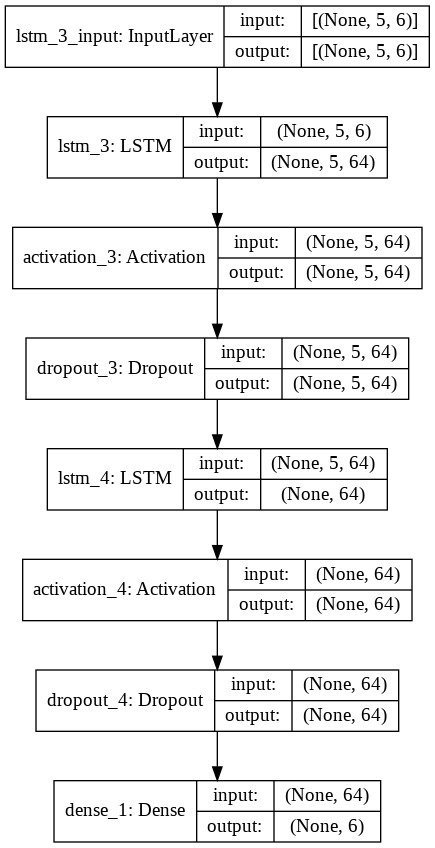

In [0]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
# Load the keras model
model = tf.keras.models.load_model(filepath=working_dir+'/many_particle.HDF5', compile=True)
#model = tf.keras.models.load_model(filepath=working_dir+'/noise_added_harmonics_pos_velocity.HDF5', compile=True)
#y_pred = model.predict(x_test)
#y_pred_classes = model.predict_classes(x_test)
#cm = confusion_matrix(y_test_classes, y_pred_classes)
#print(cm)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
  #make movie
def make_movie(file_name = '', data =None):

  lx=1.5
  ly=1.5
  lz=1.5

  for num in range(data.shape[0]):
    if num==0:
      outdump = open(working_dir+"/"+file_name, "w")
    else:
      outdump = open(working_dir+"/"+file_name, "a")
    
    outdump.write("ITEM: TIMESTEP\n")
    outdump.write("{}\n".format(num - 1))
    outdump.write("ITEM: NUMBER OF ATOMS\n")
    outdump.write("{}\n".format(data.shape[1]))
    outdump.write("ITEM: BOX BOUNDS\n")
    outdump.write("{}\t{}\n".format(-0.5*lx, 0.5*lx))
    outdump.write("{}\t{}\n".format(-0.5*lx, 0.5*ly))
    outdump.write("{}\t{}\n".format(-0.5*lz, 0.5*lz))
    outdump.write("ITEM: ATOMS index type x y z v\n")

    for j in range(data.shape[1]):
      outdump.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(j+1, "1", data[num][j][0], data[num][j][1], data[num][j][2], 0)) 
    outdump.close()
      

In [0]:
start = time.time()

actual_output = []
predicted_output = []

sim_ = training_indexes[0]

for i in range(window_size, all_data_values.shape[1]):
  predicted_output.append(model.predict(all_data_values[sim_, (i-window_size):i].reshape(-1, window_size, input_features)))
  actual_output.append(all_data_values[sim_, i])

predicted_output = np.array(predicted_output).reshape(-1, all_data_values.shape[2], all_data_values.shape[3])
actual_output = np.array(actual_output)#.reshape(-1, input_features)
print(predicted_output.shape)
print(actual_output.shape)

end = time.time()
print("Time: "+str(end - start))

make_movie(file_name = 'predicted.lammpstrj', data =predicted_output)
make_movie(file_name = 'actual.lammpstrj', data =actual_output)


(1996, 16, 3)
(1996, 16, 3)
Time: 10.656152248382568


In [0]:
# Download the denoised waveforms.
from google.colab import files
files.download(working_dir+ '/predicted.lammpstrj')
files.download(working_dir+ '/actual.lammpstrj')